In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np

from torchsummary import summary
import shutil

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

Let's build a simple MNIST model, with only 6 layers. Global Average Pooling (GAP) and dense layers are used at last for consistent weights.

In [3]:
log_batch = 10
unit_num = 16

def _make_layer(in_shape, out_shape, unit_num):
    return nn.Sequential(
        nn.Conv2d(in_shape, unit_num, 3, 1, 1),
        nn.ReLU(inplace=True),
        nn.Conv2d(unit_num, out_shape, 3, 1, 1),
        nn.ReLU(inplace=True),
    )
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv11 = nn.Conv2d(1, unit_num, 3, 1, 1)
        #self.conv12 = nn.Conv2d(unit_num, unit_num, 3, 1, 1)
        #self.conv21 = nn.Conv2d(unit_num, unit_num*2, 3, 1, 1)
        #self.conv22 = nn.Conv2d(unit_num*2, unit_num*2, 3, 1, 1)
        #self.conv31 = nn.Conv2d(unit_num*2, unit_num*4, 3, 1, 1)
        #self.conv32 = nn.Conv2d(unit_num*4, unit_num*4, 3, 1, 1)
        # why the model is like this? Any specific meaning?
        self.layer1 = _make_layer(1,unit_num,unit_num)
        self.layer2 = _make_layer(unit_num,unit_num*2,unit_num*2)
        self.layer3 = _make_layer(unit_num*2,unit_num*4,unit_num*4)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(unit_num*4, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        
        x = self.layer3(x)
        x = self.gap(x)
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        #output = F.softmax(x, dim=1)
        #x = F.log_softmax(x, dim=1)
        return x



use_cuda = torch.cuda.is_available()
model = Net()
if use_cuda:
    model = model.cuda()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
              ReLU-8           [-1, 32, 14, 14]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
             ReLU-12             [-1, 64, 7, 7]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Linear-14                   

Dataset are stored in '/dataset'. If you want to change this, remember to change the root for ClassesLoader.

In [5]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.MNIST(root = "./dataset",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./dataset",
                           transform = transform,
                           train = False)
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                 num_workers=0)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = batch_size,
                                               shuffle = True,
                                                num_workers=0)

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


/Users/xinyaoniu/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
import time

We do not want a perfect MNIST classifier. Around 97% accuracy is enough for the explanations.

In [28]:
objective = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 10

torch.set_num_threads(6)

for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10)
    
    all_start = time.time()
    op_total = 0
    sf_total = 0
    for data in data_loader_train:
        
        X_train, y_train = data
        if use_cuda:
            X_train, y_train = X_train.cuda(), y_train.cuda()
        
        sf_start = time.time()
        outputs = F.softmax(model(X_train), dim=1)
        _, pred = torch.max(outputs.data, 1)
        sf_total += time.time() - sf_start
        
        
        optimizer.zero_grad()
        loss = objective(outputs, y_train)
        op_start = time.time()
        loss.backward()
        optimizer.step()
        op_total += time.time() - op_start
        
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data).item()
        
    print('op usage=', op_total/(time.time()-all_start))
    print('sf usage=', sf_total/(time.time()-all_start))
    
    testing_correct = 0
    
    for data in data_loader_test:
        X_test, y_test = data
        if use_cuda:
            X_test, y_test = X_test.cuda(), y_test.cuda()
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data).item()
    
    print("Loss is:{:.8f}, Train Accuracy is:{:.2f}%, Test Accuracy is:{:.2f}%".format(running_loss*batch_size/len(data_train),
                                                                                      100*running_correct/len(data_train),
                                                                                      100*testing_correct/len(data_test)))

Epoch 0/10
----------
op usage= 0.6314074515457192
sf usage= 0.2863030634733311
Loss is:1.48143289, Train Accuracy is:97.98%, Test Accuracy is:98.03%
Epoch 1/10
----------
op usage= 0.6452450412389229
sf usage= 0.2759783953836105
Loss is:1.47860262, Train Accuracy is:98.28%, Test Accuracy is:98.24%
Epoch 2/10
----------
op usage= 0.6439406329426658
sf usage= 0.2768174840171578
Loss is:1.47727386, Train Accuracy is:98.38%, Test Accuracy is:97.29%
Epoch 3/10
----------
op usage= 0.7081536197208924
sf usage= 0.22728933245889787
Loss is:1.47694621, Train Accuracy is:98.41%, Test Accuracy is:98.73%
Epoch 4/10
----------
op usage= 0.7506355666184497
sf usage= 0.19451562214289406
Loss is:1.47574888, Train Accuracy is:98.56%, Test Accuracy is:98.32%
Epoch 5/10
----------
op usage= 0.7734661442070389
sf usage= 0.17684641497894085
Loss is:1.47430059, Train Accuracy is:98.70%, Test Accuracy is:98.53%
Epoch 6/10
----------
op usage= 0.8128415077142023
sf usage= 0.1463001088139844
Loss is:1.4764013

Now, for the Explanations.
1. wrap the model.
2. create a classesLoader.
3. set layers, model target and classes target.
4. create Explainer, train the model and generate explanations.

Here we choose [1,2,4,8] as target classes

In [35]:
from Explainer import *
import Explainer
import utils 
import ClassesLoader 
import ModelWrapper 


m1 = ModelWrapper.PytorchModelWrapper(model,input_size = [1,28,28])

classes = ClassesLoader.MNISTLoader(root = './dataset')

layers = ["layer3"]

classesNos = [1,2,4,8]
m1.target = ("fc",classesNos)
classes.targetNos = classesNos
n_components = 15

for layer_name in layers:
    
    title = "MNIST_"+layer_name + "_{}_{}".format(n_components,classesNos)
    try:
        shutil.rmtree('./Explainers/'+title)
    except:
        pass
    
    Exp = Explainer.Explainer(title = title,
                    layer_name = layer_name,
                    classesNos = classesNos,
                    utils = utils.utils(img_size = (28,28,1)),
                    #best_n = True,
                    
                    n_components= n_components

                    #min_step=5
                   )
    
    try:
        Exp.train_model(m1,classes)
    except:
        Exp.reducer = None
        Exp.train_model(m1,classes)
    
    Exp.generate_features(m1,classes)
    
    Exp.save_features()
    
    Exp.generate_image_LR_file(classes)
    
    Exp.save()

0it [00:00, ?it/s]

Training reducer:
Loading data


4it [00:07,  1.91s/it]


Loading complete, with size of (24393, 7, 7, 64)
Training will take around a minute, please wait for a while...
reducer trained, spent 44.180405139923096 s


0it [00:00, ?it/s]

fidelity: [0.3569469  0.3512723  0.09310395 0.15824845]
loading data


4it [00:07,  1.96s/it]
  0%|          | 0/15 [00:00<?, ?it/s]

estimating weight:


100%|██████████| 15/15 [03:48<00:00, 15.23s/it]
0it [00:00, ?it/s]

generating features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
loading training data


4it [00:09,  2.50s/it]
100%|██████████| 15/15 [00:01<00:00, 13.03it/s]
0it [00:00, ?it/s]

Generate explanations with fullset condition


0it [00:00, ?it/s]


InvocationException: GraphViz's executables not found

Global Explanations for 1,2,4,8

In [41]:
from IPython.display import HTML, display
display(HTML("".join(["<table><tr>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/GE/1.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/GE/2.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/GE/4.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/GE/8.jpg'></td>",
                      "</tr></table>"])))

,,,


Local explanations for a '1'

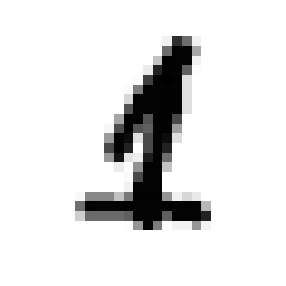

InvocationException: Program terminated with status: 1. stderr follows: Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_0.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_0.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\0.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\0.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_8.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_8.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\8.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\8.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_13.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_13.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\13.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\13.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_1.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_1.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\1.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\1.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_6.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_6.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\6.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\6.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_3.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_3.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\3.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\3.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_9.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_9.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\9.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\9.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_14.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_14.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\14.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\14.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_11.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_11.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\11.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\11.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_2.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_2.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\2.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\2.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_5.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_5.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\5.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\5.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_10.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_10.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\10.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\10.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_4.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_4.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\4.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\4.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_12.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_12.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\12.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\12.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_7.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\explanations\1\feature_7.jpg"
Warning: No such file or directory while opening /Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\7.jpg
Error: No or improper image file="/Users/xinyaoniu/Documents/InvertibleCE\Explainers\MNIST_layer3_15_[1, 2, 4, 8]\feature_imgs\7.jpg"
in label of node 1


In [43]:
(X,y),(tX,ty) = classes.load_all()
x = tX[np.where(ty[:,1] == 1)][274]
utils.utils(img_size = (28,28,1)).show_img([x])

Exp.local_explanations(x,m1,classes)

In [11]:
from IPython.display import HTML, display
display(HTML("".join(["<table><tr>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/explanations/all/0_1.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/explanations/all/0_2.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/explanations/all/0_4.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/explanations/all/0_8.jpg'></td>",
                      "</tr></table>"])))

,,,


Local explanation for a '2'

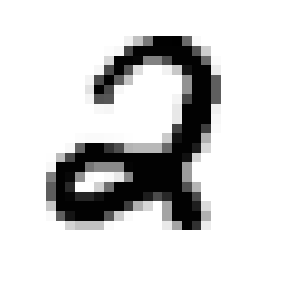

In [15]:
(X,y),(tX,ty) = classes.load_all()
x = tX[np.where(ty[:,2] == 1)][10]
utils.utils(img_size = (28,28,1)).show_img([x])

Exp.local_explanations(x,m1,classes)

In [16]:
from IPython.display import HTML, display
display(HTML("".join(["<table><tr>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/explanations/all/1_1.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/explanations/all/1_2.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/explanations/all/1_4.jpg'></td>",
                      "<td><img src='Explainers/MNIST_layer3_15_[1, 2, 4, 8]/explanations/all/1_8.jpg'></td>",
                      "</tr></table>"])))

,,,
